<center><h1>An object oriented Python Downloader for Sentinel-2 Products</h1></center>

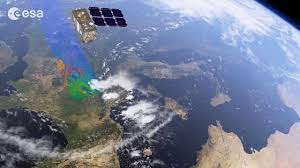

<p> The following code downloads Sentinel-2 Level2A products in a fast and clean way from CreoDIAS API. The products are stored in a local directory, defined by the user. 

<div class="alert alert-block alert-info">
<b>Tip:</b> User has to initialize the downloader object by entering the desired tile, start and end date in yyyy-mm-dd format along with the maximum allowed cloud coverage in the tile, all given as strings
</div>|

In [ ]:
import datetime,requests,os,shutil
from tqdm.notebook import tqdm_notebook
from pathlib import Path


class Sentinel2Downloader:
    
    def __init__(self,tile,startDate,endDate,cloudCoverage,relativeOrbit=None):
        try:
            d1 = datetime.datetime.strptime(startDate, '%Y-%m-%d')
            d2 = datetime.datetime.strptime(endDate, '%Y-%m-%d')
        except ValueError:
            print("Invalid start date entered!")
            return 
        self.tile = tile
        self.startDate = startDate
        self.endDate = endDate
        self.cloud = str(cloudCoverage)
        self.rob = relativeOrbit
        self.url = 'https://finder.creodias.eu/resto/api/collections/Sentinel2/search.json?maxRecords=10&processingLevel=LEVEL2A&productIdentifier=%25'+self.tile+'%25&startDate='+self.startDate+'T00%3A00%3A00Z&completionDate='+self.endDate+'T23%3A59%3A59Z&sortParam=startDate&sortOrder=ascending&status=0%7C34%7C37&dataset=ESA-DATASET&cloudCover=%5B0%2C'+self.cloud+'%5D&'
        self.token = None
        self.response = None
        
    def _get_next_page(self,links):
        for link in links:
            if link['rel'] == 'next':
                return link['href']
        return False
    
    def _get_token(self,username, password):
        token_data = {
            'client_id': 'CLOUDFERRO_PUBLIC',
            'username': username,
            'password': password,
            'grant_type': 'password'
        }
        return token_data
        
    def search_products(self,username,password):
        
        TOKEN_URL = 'https://auth.creodias.eu/auth/realms/DIAS/protocol/openid-connect/token'
        
        token_data = self._get_token(username,password)
        response = requests.post(TOKEN_URL, data=token_data).json()

        try:
            token = response['access_token']
        except KeyError:
            raise RuntimeError('Unable to get token. Response was {response}')
            return 
        
        query_response = {}
        tmp_url = self.url
        while tmp_url:
            response = requests.get(tmp_url)
            response.raise_for_status()
            data = response.json()
            for feature in data['features']:
                query_response[feature['id']] = feature
            tmp_url = self._get_next_page(data['properties']['links'])
        
        self.response = query_response
        self.token = token
        
        ids = [result['id'] for result in query_response.values()]
        print("Found {} products".format(len(ids)))

        
    def download_products(self,outdir,unzip=True):
        
        query_response = self.response
        ids = [result['id'] for result in query_response.values()]
        token = self.token

        if len(ids) == 0:
            print("No products to download!")
            return 
        if self.token == None:
            print("No or failed authentication!")
            return
        
        DOWNLOAD_URL = 'https://zipper.creodias.eu/download'
        tile_name = self.tile

        for id in tqdm_notebook(ids):
            identifier = query_response[id]['properties']['productIdentifier'].split('/')[-1]
            sensing_date = identifier.split('.')[0].split('_')[2]
            sensing_day = sensing_date[-2:]
            sensing_year = sensing_date[:4]
            sensing_month = sensing_date[4:6]
            url = '{}/{}?token={}'.format(DOWNLOAD_URL,id,token)
            outdir = outdir + '/'+sensing_year
            if not os.path.exists(outdir):
                os.mkdir(outdir)
            outdir = outdir + '/' + tile_name
            if not os.path.exists(outdir):
                os.mkdir(outdir)
            outdir = outdir +'/'+sensing_month
            if not os.path.exists(outdir):
                os.mkdir(outdir)
            outfile = Path(outdir) / '{}.zip'.format(identifier)
            if os.path.exists(outfile):
                continue
            outfile_temp = str(outfile) + '.incomplete'
            try:
                downloaded_bytes = 0
                req =  requests.get(url, stream=True, timeout=100)
                chunk_size = 2 ** 20  # download in 1 MB chunks
                with open(outfile_temp, 'wb') as fout:
                    for chunk in req.iter_content(chunk_size=chunk_size):
                        if chunk:  # filter out keep-alive new chunks
                            fout.write(chunk)
                            downloaded_bytes += len(chunk)
                shutil.move(outfile_temp, str(outfile))
            finally:
                try:
                    Path(outfile_temp).unlink()
                except OSError:
                    pass

## Example of usage

In [ ]:
# create and initialize a Downloader object with the required parameters
s2d = Sentinel2Downloader(tile='34UEG',startDate='2020-01-01',endDate='2020-01-31',cloudCoverage='90')
# authenticate and search products 
s2d.search_products(username = 'test@gmail.com',password='test')
# download the harvested products
s2d.download_products(outdir='/home/eouser')